In [2]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

df = pl.read_csv("./DSU-Dataset.csv")
col = df["Date"].str.to_date()
df = df.with_columns(col)

df.head()

Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted
str,date,f64,str,i64,i64
"""A""",2018-01-01,0.0,"""BREATHING PROBLEM""",1,1
"""A""",2018-01-01,0.0,"""BURN""",1,0
"""A""",2018-01-01,0.0,"""SHAKING""",1,1
"""A""",2018-01-01,0.0,"""VOMITING""",1,0
"""A""",2018-01-01,1.0,"""FROSTBITE""",1,0


In [3]:
block_ranges = { 1: range(0, 6),
                 2: range(6, 12),
                 3: range(12, 18),
                 4: range(18, 24) }

hourly_blocks_df = df.with_columns(
    pl.col("Hour").map_elements(lambda hr: next(block for block, hrs in block_ranges.items() if hr in hrs)).alias("Hour")
)
hourly_blocks_df = hourly_blocks_df.group_by(["Site", "Date", "Hour"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())
hourly_blocks_df = hourly_blocks_df.sort(["Site", "Date", "Hour"])
hourly_blocks_df = hourly_blocks_df.with_columns(
    [
        pl.col("Date").dt.year().alias("Year"),
        pl.col("Date").dt.month().alias("Month"),
        pl.col("Date").dt.day().alias("Day"),
        pl.col("Date").dt.weekday().alias("Weekday"),
    ]
).drop("Date").select(["Site", "Year", "Month", "Day", "Weekday", "Hour", "ED Enc", "ED Enc Admitted"])

# remove covid data
hourly_blocks_df = hourly_blocks_df.filter(pl.col("Year") != 2020).filter(pl.col("Year") != 2021)

hourly_blocks_df.head()

Site,Year,Month,Day,Weekday,Hour,ED Enc,ED Enc Admitted
str,i32,i8,i8,i8,i64,i64,i64
"""A""",2018,1,1,1,1,16,6
"""A""",2018,1,1,1,2,25,8
"""A""",2018,1,1,1,3,52,16
"""A""",2018,1,1,1,4,36,10
"""A""",2018,1,2,2,1,18,5


# Site A Random Forest Model

In [4]:
siteA_train = hourly_blocks_df.filter(pl.col("Site") == "A")
siteA_X = siteA_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteA_Y = siteA_train.select(["ED Enc", "ED Enc Admitted"])
siteA_model = RandomForestRegressor().fit(siteA_X, siteA_Y)
siteA_X_train, siteA_X_test, siteA_Y_train, siteA_Y_test = train_test_split(siteA_X, siteA_Y, test_size=0.2, random_state=42)

In [5]:
print(f"R² score of {siteA_model.score(siteA_X_test, siteA_Y_test)}")

R² score of 0.9495766148187703


# Site B Random Forest Model

In [6]:
siteB_train = hourly_blocks_df.filter(pl.col("Site") == "B")
siteB_X = siteB_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteB_Y = siteB_train.select(["ED Enc", "ED Enc Admitted"])
siteB_model = RandomForestRegressor().fit(siteB_X, siteB_Y)
siteB_X_train, siteB_X_test, siteB_Y_train, siteB_Y_test = train_test_split(siteB_X, siteB_Y, test_size=0.2, random_state=42)

In [7]:
print(f"R² score of {siteB_model.score(siteB_X_test, siteB_Y_test)}")

R² score of 0.9504574141193554


# Site C Random Forest Model

In [8]:
siteC_train = hourly_blocks_df.filter(pl.col("Site") == "C")
siteC_X = siteC_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteC_Y = siteC_train.select(["ED Enc", "ED Enc Admitted"])
siteC_model = RandomForestRegressor().fit(siteC_X, siteC_Y)
siteC_X_train, siteC_X_test, siteC_Y_train, siteC_Y_test = train_test_split(siteC_X, siteC_Y, test_size=0.2, random_state=42)

In [9]:
print(f"R² score of {siteC_model.score(siteC_X_test, siteC_Y_test)}")

R² score of 0.9462559224893108


# Site D Random Forest Model

In [10]:
siteD_train = hourly_blocks_df.filter(pl.col("Site") == "D")
siteD_X = siteD_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteD_Y = siteD_train.select(["ED Enc", "ED Enc Admitted"])
siteD_model = RandomForestRegressor().fit(siteD_X, siteD_Y)
siteD_X_train, siteD_X_test, siteD_Y_train, siteD_Y_test = train_test_split(siteD_X, siteD_Y, test_size=0.2, random_state=42)

In [11]:
print(f"R² score of {siteD_model.score(siteD_X_test, siteD_Y_test)}")

R² score of 0.9281134221158489


# Linear regression?
We can see from the EDA that, if we take out the COVID data, the data fits pretty closely to a line for each site.

## Site A 

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge

best_alpha = 0
best_score = 0
# find the best alpha
for i in range(1, 100):
    alpha = 1/i
    siteA_linreg = Ridge(alpha=alpha).fit(siteA_X, siteA_Y)
    score = siteA_linreg.score(siteA_X_test, siteA_Y_test)
    if score > best_score:
        best_score = score
        best_alpha = alpha

print(f"Best alpha: {best_alpha}, Best R² score: {best_score}")

Best alpha: 1.0, Best R² score: 0.44922867398679767


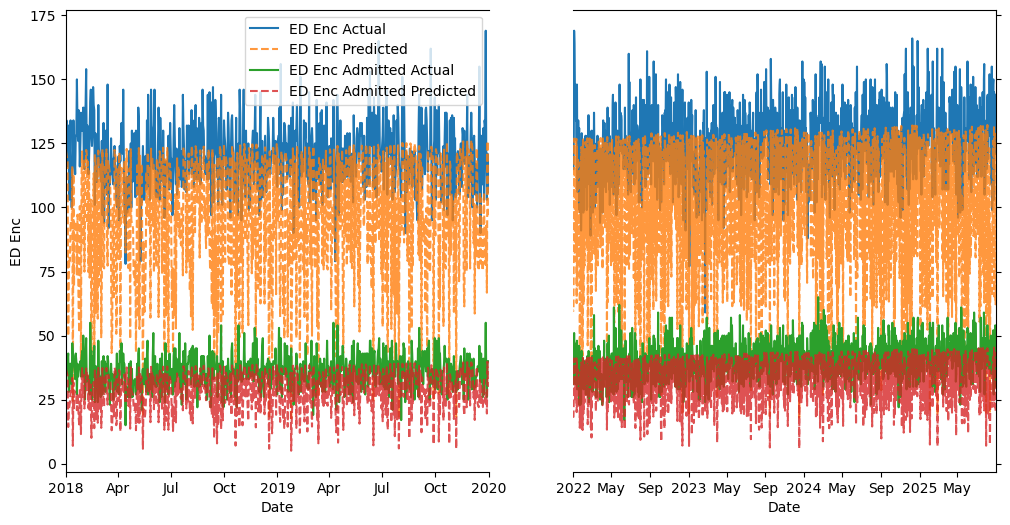

In [22]:
plot_df = siteA_train.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteA_linreg.predict(siteA_X_train)
predict_df = siteA_X_train.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual", ax=ax)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", linestyle="--", alpha=0.8, ax=ax1)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", ax=ax1)
sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", linestyle="--", alpha=0.8, ax=ax1)

min_date = plot_df["Date"].min()
max_date = plot_df["Date"].max()
begin_covid_date = df.filter(pl.col("Date").dt.year() == 2020).select(pl.col("Date")).min()
end_covid_date = df.filter(pl.col("Date").dt.year() == 2021).select(pl.col("Date")).max()

ax.set_xlim(left=min_date, right=begin_covid_date)
ax1.set_xlim(left=end_covid_date, right=max_date)
ax.spines.right.set_visible(False)
ax1.spines.left.set_visible(False)
ax.tick_params(labelright=False)
ax1.yaxis.tick_right()

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
plt.show()

## ok so clearly the model just needs some tweaking, but then we can possibly can get a more accurate model than random forest?

## Site B

In [ ]:
siteB_linreg = LinearRegression().fit(siteB_X, siteB_Y)
print(f"R² score of {siteB_linreg.score(siteB_X_test, siteB_Y_test)}")

R² score of 0.5250426761592966


## Site C

In [ ]:
siteC_linreg = LinearRegression().fit(siteC_X, siteC_Y)
print(f"R² score of {siteC_linreg.score(siteC_X_test, siteC_Y_test)}")

R² score of 0.4191278197685471


## Site D

In [ ]:
siteD_linreg = LinearRegression().fit(siteD_X, siteD_Y)
print(f"R² score of {siteD_linreg.score(siteD_X_test, siteD_Y_test)}")

R² score of 0.2881915418680184
